In [ ]:
# https://huggingface.co/dandelin/vilt-b32-finetuned-vqa

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
!unzip DATASET.zip

Archive:  DATASET.zip
  inflating: synpic100176.jpg        
  inflating: synpic100132.jpg        
  inflating: synpic100228.jpg        
  inflating: synpic60423.jpg         
  inflating: synpic60703.jpg         
  inflating: synpic60254.jpg         
  inflating: synpic60831.jpg         
  inflating: synpic60543.jpg         
  inflating: synpic60096.jpg         
  inflating: synpic59935.jpg         
  inflating: synpic59536.jpg         
  inflating: synpic59356.jpg         
  inflating: synpic59126.jpg         
  inflating: synpic58261.jpg         
  inflating: synpic58902.jpg         
  inflating: synpic59131.jpg         
  inflating: synpic57368.jpg         
  inflating: synpic58547.jpg         
  inflating: synpic57935.jpg         
  inflating: synpic57813.jpg         
  inflating: synpic56422.jpg         
  inflating: synpic57317.jpg         
  inflating: synpic57520.jpg         
  inflating: synpic56841.jpg         
  inflating: synpic56799.jpg         
  inflating: synpic57237.jpg

In [ ]:
import torch
from transformers import ViltProcessor, ViltForQuestionAnswering, AdamW
from PIL import Image
import json
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

from transformers import ViltForQuestionAnswering
import transformers
transformers.utils.logging.set_verbosity_error
import warnings
warnings.filterwarnings('ignore')



In [ ]:
import pandas as pd

df = pd.read_json('DATASET.json')

In [ ]:
print(df)

       qid phrase_type                         qid_linked_id  \
0        0    freeform  03f451ca-de62-4617-9679-e836026a7642   
1        1    freeform  06e26b2c-04b9-42bc-8e98-1de30a0f7682   
2        2    freeform  0d0e8b6b-7753-4788-9b6d-dc7f25250c3f   
3        3    freeform  0e90b6bc-265f-490b-a039-509b9907a3cb   
4        4    freeform  1179f612-12e0-4dda-aee0-f14a5200be7b   
...    ...         ...                                   ...   
2243  2243        para  6e01da36-ccda-4462-81c4-c7b5e495fb99   
2244  2244    freeform  9a4e1869-5c76-4af6-81e4-1864db18bbbe   
2245  2245        para  9a4e1869-5c76-4af6-81e4-1864db18bbbe   
2246  2246    freeform  e2c3565f-a137-406d-8ab0-de869c86cbee   
2247  2247        para  e2c3565f-a137-406d-8ab0-de869c86cbee   

                                         image_case_url       image_name  \
0     https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...  synpic54610.jpg   
1     https://medpix.nlm.nih.gov/case?id=b197277b-69...  synpic29265.jpg   
2  

In [ ]:
answer_to_label = {answer: idx for idx, answer in enumerate(df['answer'].unique())}
answer_to_label = {str(k): v for k, v in answer_to_label.items()}
print(answer_to_label)

{'Yes': 0, 'No': 1, 'ultrasound': 2, 'no': 3, 'The extremities': 4, 'yes': 5, 'left temporal lobe': 6, 'Cardiovascular': 7, 'vasculature': 8, 'MRI Diffusion Weighted': 9, 'the brain': 10, 'Posterior-Anterior': 11, 'Chest X-ray': 12, 'Axial': 13, 'Asymmetric': 14, 'Pulmonary nodules': 15, 'Free air': 16, 'hypodense lesion': 17, 'GI': 18, 'Ring-enhancing lesion': 19, 'Diffuse': 20, 'CT': 21, 'Chest x-ray': 22, 'Pancreas': 23, 'Right upper lobe': 24, 'Hypodense': 25, 'Left hepatic lobe': 26, 'Lungs': 27, 'Bilateral': 28, 'Cirrhosis': 29, 'Atherosclerotic calcification': 30, 'right parietal lobe': 31, 'Chest': 32, 'metastasis': 33, 'axial': 34, 'PA': 35, 'Enlarged': 36, 'Volume loss': 37, 'one': 38, 'extraluminal air and small fluid collection': 39, 'Nodular opacities': 40, 'extra-axial and at the right choroidal fissure': 41, 'Prior surgery': 42, 'Ring-enhancing lesions': 43, 'right temporal lobe': 44, 'Gallstones': 45, 'Right': 46, 'abscess': 47, 'Cystic lesions': 48, 'middle mogul': 49,

In [ ]:
label_to_answer = {idx: answer for answer, idx in answer_to_label.items()}
label_to_answer = {str(k): v for k, v in label_to_answer.items()}
print(label_to_answer)

{'0': 'Yes', '1': 'No', '2': 'ultrasound', '3': 'no', '4': 'The extremities', '5': 'yes', '6': 'left temporal lobe', '7': 'Cardiovascular', '8': 'vasculature', '9': 'MRI Diffusion Weighted', '10': 'the brain', '11': 'Posterior-Anterior', '12': 'Chest X-ray', '13': 'Axial', '14': 'Asymmetric', '15': 'Pulmonary nodules', '16': 'Free air', '17': 'hypodense lesion', '18': 'GI', '19': 'Ring-enhancing lesion', '20': 'Diffuse', '21': 'CT', '22': 'Chest x-ray', '23': 'Pancreas', '24': 'Right upper lobe', '25': 'Hypodense', '26': 'Left hepatic lobe', '27': 'Lungs', '28': 'Bilateral', '29': 'Cirrhosis', '30': 'Atherosclerotic calcification', '31': 'right parietal lobe', '32': 'Chest', '33': 'metastasis', '34': 'axial', '35': 'PA', '36': 'Enlarged', '37': 'Volume loss', '38': 'one', '39': 'extraluminal air and small fluid collection', '40': 'Nodular opacities', '41': 'extra-axial and at the right choroidal fissure', '42': 'Prior surgery', '43': 'Ring-enhancing lesions', '44': 'right temporal lobe

In [ ]:
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=answer_to_label,
                                                 label2id=label_to_answer)
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.3.bias', 'classifier.1.bias', 'classifier.0.weight', 'classifier.3.weight', 'classifier.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
print(len(config.id2label))
print(len(answer_to_label))

3129
557


In [ ]:
class MedicalVQADataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, processor, answer_to_label):
        self.data = dataframe
        self.processor = processor
        self.answer_to_label = answer_to_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image + text
        item = self.data.iloc[idx]

        image = Image.open(item["image_name"]).resize((224, 224))
        text = item["question"]

        encoding = self.processor(images=image, text=text, padding="max_length", truncation=True, return_tensors="pt")
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        answer = item['answer']
        label = self.answer_to_label.get(answer, -1)  # Returns -1 if answer not in mapping (should not happen)

        targets = torch.zeros(len(self.answer_to_label))
        targets[label] = 1.0
        encoding["labels"] = targets

        return encoding

from transformers import ViltProcessor

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

train_dataset = MedicalVQADataset(dataframe=train_df, processor=processor, answer_to_label=answer_to_label)
test_dataset = MedicalVQADataset(dataframe=val_df, processor=processor, answer_to_label=answer_to_label)


In [ ]:
print(train_dataset[1333])

{'input_ids': tensor([  101,  2003,  2045,  1052,  2638,  2819, 25918,  9956,  2638,  2819,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-0.8510, -0.7098, -0.4902,  ..., -0.3020, -0.2941, -0.2941],
         [-0.8510, -0.7176, -0.4980,  ..., -0.4039, -0.3961, -0.3961],
         [-0.8510, -0.7255, -0.4980,  ..., -0.5765, -0.5686, -0.5686],
         ...,
         [-0.9843, -0.9922, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9922, -1.0000, -1.0000,  ..., -1.

In [ ]:
# setup Trainer for training
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=300,
    save_total_limit = 5,
    # https://github.com/huggingface/transformers/issues/14051 evaluation_strategy save_strategy errors
    evaluation_strategy="epoch", #load_best_model=True requires evaluation_strategy == save_strategy,
    save_strategy='epoch', #https://huggingface.co/transformers/v4.4.2/main_classes/trainer.html
    load_best_model_at_end = True,
    # When set to True, the parameters save_strategy and save_steps will be ignored and the model will be saved after each evaluation.
    #metric_for_best_model = 'f1'
    metric_for_best_model = 'accuracy'
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
accuracy_sum=[]
precision_sum=[]
f1_sum=[]
recall_sum=[]

In [ ]:
def compute_metrics(pred):
    labels = np.argmax(pred.label_ids, axis=1)
    #labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    accuracy_sum.append(acc)
    precision_sum.append(precision)
    f1_sum.append(f1)
    recall_sum.append(recall)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks =[EarlyStoppingCallback(early_stopping_patience=5)],
    #change callback from 3 to 5
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,5.064815,0.171852,0.076342,0.151526,0.171852
2,24.490500,4.838281,0.281481,0.189282,0.190311,0.281481
3,4.582500,4.770627,0.266667,0.184642,0.268457,0.266667
4,4.109300,4.777622,0.293333,0.231717,0.272287,0.293333
5,4.109300,4.716037,0.331852,0.277560,0.266851,0.331852
6,3.492900,4.918956,0.343704,0.297382,0.271806,0.343704
7,2.688100,4.803799,0.373333,0.344344,0.330960,0.373333
8,2.045500,5.155110,0.321481,0.297335,0.324511,0.321481
9,1.502200,5.123237,0.395556,0.373458,0.373779,0.395556
10,1.502200,5.068651,0.417778,0.397788,0.399254,0.417778


TrainOutput(global_step=9456, training_loss=2.415617106126246, metrics={'train_runtime': 3013.5594, 'train_samples_per_second': 156.592, 'train_steps_per_second': 39.223, 'total_flos': 816899083228800.0, 'train_loss': 2.415617106126246, 'epoch': 24.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 7.626138687133789,
 'eval_accuracy': 0.45481481481481484,
 'eval_f1': 0.44031613619382926,
 'eval_precision': 0.4455455713412353,
 'eval_recall': 0.45481481481481484,
 'eval_runtime': 22.8287,
 'eval_samples_per_second': 29.568,
 'eval_steps_per_second': 7.403,
 'epoch': 24.0}

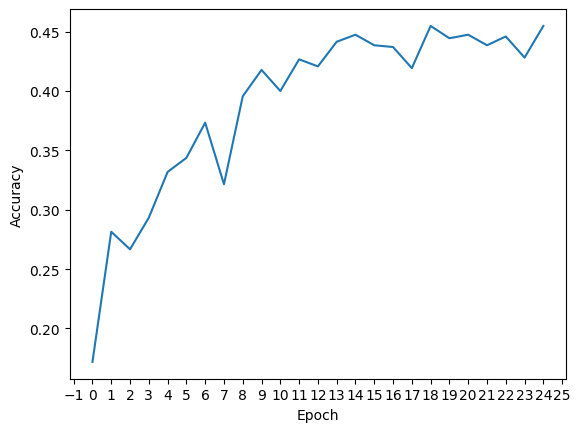

In [ ]:
# plot validate accurarcy:
import matplotlib.ticker as ticker
ax = plt.axes()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(accuracy_sum)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

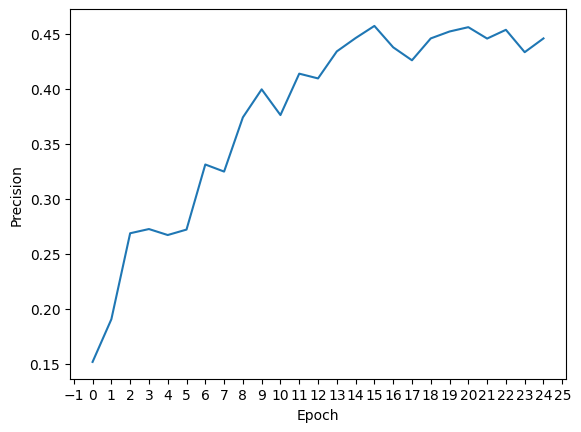

In [ ]:
# plot Precision:
ax = plt.axes()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(precision_sum)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

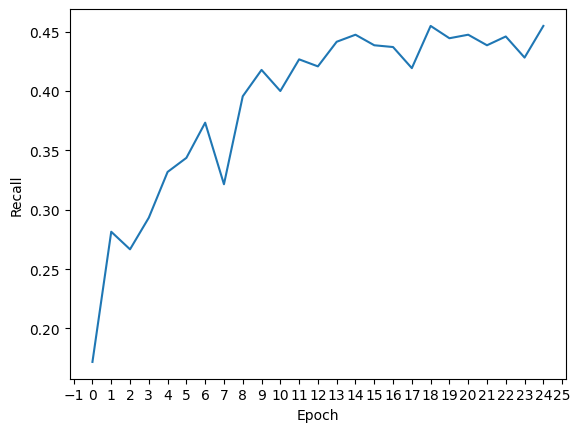

In [ ]:
# plot f1:
ax = plt.axes()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(recall_sum)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()

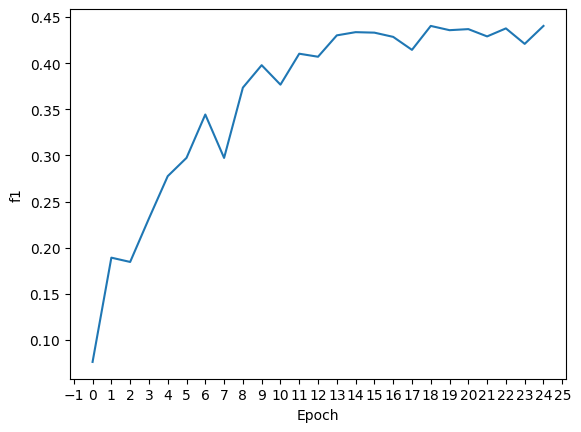

In [ ]:
# plot recall:

ax = plt.axes()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(f1_sum)
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.show()